# Forecasting Change in price percentage of IBM

#### By: Daniel Ford

In [1]:
import wrangle as wg
import explore as ex
import model as mo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt 
import scipy.stats as stats
import statsmodels.api as sm

plt.rcParams["figure.figsize"] = [16,9]  # width, height
plt.rcParams['xtick.direction'] = 'out'
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Wrangle


## Acquire

this is gathered data of the 2011 DOW Jones Index 
colected from the UCI machine learning repository

This dataframe has 750 observation over 14 rows

In [2]:
# simple function to retrieve dataframe
df = wg.get_dow()

In [3]:
df.shape

(750, 16)

In [4]:
df.head(3)

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,NaN,NaN,$16.71,$15.97,-4.42849,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223,239655616.0,$16.19,$15.79,-2.47066,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.024959,242963398.0,$15.87,$16.13,1.63831,12,0.189994


## Clean


This data was already very clean but to make it more useable I:

   - changed data types of select columns
   - replaced unnecessary characters
   - convertedd date to date-time and indexed
   - dropped select columns
   - backfilled missing information

In [5]:
# this is a function to quickly clean the data for analysis
df = wg.prep_DOW(df)
df.head()

,stock,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
date,,,,,,,,,,,,,,
2011-01-04,IBM,161.54,164.42,161.12,164.27,19081936,1.68998,-24.820375,25381792.0,164.42,164.05,-0.225033,35,0.456565
2011-01-04,TRV,59.09,60.01,58.37,59.71,16608737,1.04925,17.569654,14126721.0,59.83,59.58,-0.417851,68,0.686652
2011-01-04,KO,65.20,67.48,65.03,67.22,39265955,3.09816,31.529107,29853434.0,67.22,67.27,0.074383,73,0.699197
2011-01-04,XOM,83.86,84.94,82.61,84.68,77569311,0.97782,-6.951645,83364516.0,84.26,85.95,2.005700,40,0.555031
2011-01-04,PG,61.08,62.30,60.61,62.08,43453701,1.63720,5.084613,41351155.0,62.17,61.90,-0.434293,26,0.853737


## My first question was which stock had the best positive percent change average.

In [6]:
# This is a quick groupby function that aggregates 2 varriables by mean min and max for simple comparetive analysis
ex.quick_group(df,'stock', 'percent_change_price')

   stock      mean       min      max
22   PFE  0.591685  -3.41018  6.10225
12   IBM  0.587680  -3.27004  3.79122
17  KRFT  0.544360  -2.73973  5.13709
1    AXP  0.521029  -4.75570  6.34668
7     DD  0.362452  -5.43437  4.96970
6    CVX  0.340060  -6.02850  3.67084
26   UTX  0.306830  -4.32184  5.44794
14   JNJ  0.270470  -4.07609  5.98842
2     BA  0.253427  -3.80463  5.65488
29   XOM  0.240347  -6.14075  4.20420
19   MMM  0.207030  -3.56194  4.11705
18   MCD  0.196842  -4.08673  2.71145
13  INTC  0.188712  -3.78054  9.88223
8    DIS  0.175203  -6.01432  6.39706
4    CAT  0.152660  -5.07571  5.64811
25   TRV  0.110706  -4.92066  3.53501
10    HD  0.108416  -5.64885  5.06440
16    KO  0.081142  -4.49302  3.31063
28   WMT  0.079834  -3.82828  2.57463
24     T  0.059002  -3.40829  5.51344
23    PG -0.017015  -2.97628  3.48275
20   MRK -0.020566  -8.13204  6.67656
15   JPM -0.070105  -4.48936  4.34783
27    VZ -0.124289  -3.46789  2.75107
9     GE -0.240471  -4.36992  4.00421
0     AA -0.

### the best three in this regard are
- PFE
- IBM
- KRFT

## Next I wanted to find what was the highest valued stock by price point

In [7]:
# This is a quick groupby function that aggregates 2 varriables by mean min and max for simple comparetive analysis
ex.quick_group(df,'stock', 'open')

   stock      mean     min     max
12   IBM  162.2024  147.00  172.11
4    CAT  103.0672   92.71  116.24
6    CVX  100.8808   90.95  109.74
19   MMM   91.5300   85.70   97.58
26   UTX   83.7964   78.27   90.03
29   XOM   81.9584   73.72   88.10
18   MCD   77.1220   73.50   82.32
2     BA   73.2972   66.15   80.35
16    KO   65.2824   62.32   68.10
23    PG   64.0188   60.96   66.80
14   JNJ   62.4644   58.67   67.31
25   TRV   59.1104   53.12   63.56
28   WMT   53.8724   51.73   56.45
7     DD   52.7068   48.30   56.42
1    AXP   46.4880   43.30   51.39
15   JPM   44.5328   40.50   47.20
11   HPQ   41.7368   34.79   48.45
8    DIS   41.1944   37.74   43.53
10    HD   36.5332   33.46   39.30
27    VZ   36.5208   34.88   38.53
20   MRK   34.3800   32.09   37.26
17  KRFT   32.3836   30.53   34.97
24     T   29.6128   27.42   31.60
21  MSFT   26.0464   23.79   28.20
13  INTC   21.4044   19.53   23.32
9     GE   19.8344   18.31   21.51
22   PFE   19.7160   17.70   21.14
5   CSCO   18.1224  

### The top three highest valued stock are
- IBM
- CAT
- CVX

for posterity, I also double checked close, and these three were still the highest

# Exploration

As IBM is the highest valued and has a high positve percent change, this will be the stock I am forecasting, with that said, there are minimal total observations per stock at roughly 25 per.

In [8]:
# this function creates a dataframe of only IBM observations
df = wg.split_ibm(df)
df.head(3)

,stock,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
date,,,,,,,,,,,,,,
2011-01-04,IBM,161.54,164.42,161.12,164.27,19081936.0,1.68998,-24.820375,25381792.0,164.42,164.05,-0.225033,35.0,0.456565
2011-01-14,IBM,147.00,150.00,146.00,150.00,15335348.0,2.04082,-34.723320,23492843.0,149.82,155.50,3.791220,25.0,0.433333
2011-01-21,IBM,149.82,156.78,149.38,155.50,35770931.0,3.79122,133.258032,15335348.0,155.42,159.21,2.438550,18.0,0.418006


In [9]:
#this resamples and splits our IBM dataframe, to counter data leakage
train, validate, split = wg.resample_and_split(df)

22 13 9


## How do the distributions look?

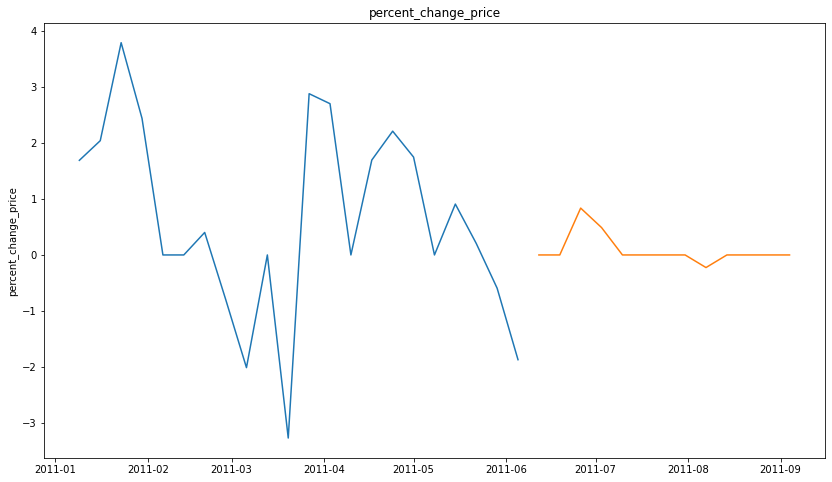

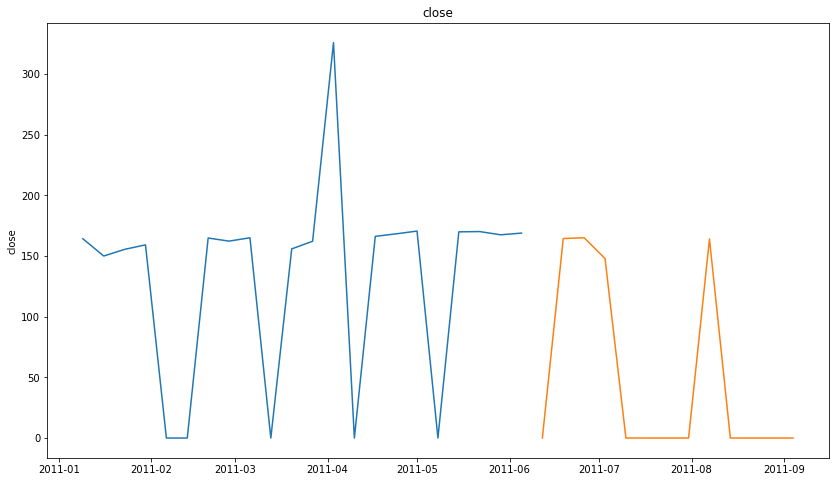

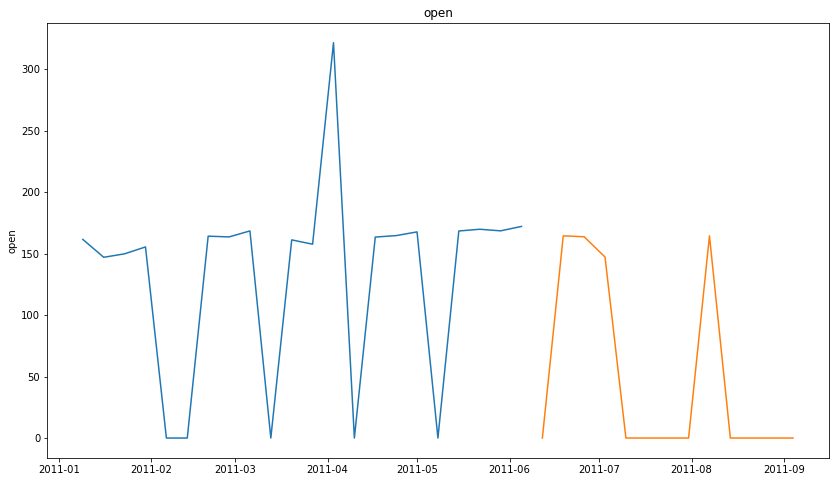

In [10]:
ex.distributions(train, validate)

### possibly some seasonality, really not enough data to be sure

## Is there any seasonality or trend?

In [11]:
# we'll make a new column to help get more insights
train['month'] = train.index.strftime('%m-%b')

<AxesSubplot:xlabel='month', ylabel='percent_change_price'>

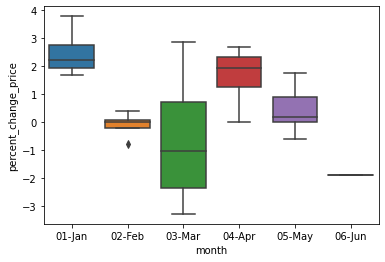

In [12]:
# box plot for percent change price by monthbbb
sns.boxplot(data = train, x = 'month', y = 'percent_change_price')

<AxesSubplot:xlabel='month', ylabel='close'>

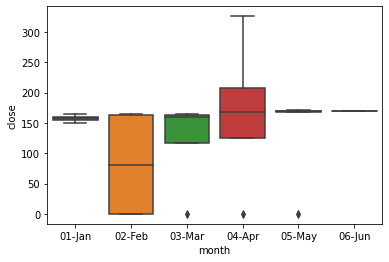

In [13]:
sns.boxplot(data = train, x = 'month', y = 'close')

<AxesSubplot:xlabel='month', ylabel='open'>

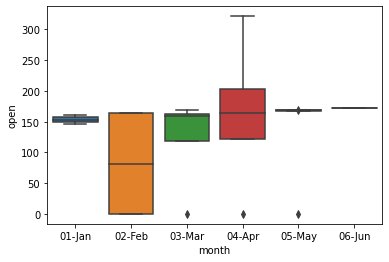

In [14]:
sns.boxplot(data = train, x = 'month', y = 'open')

### there does seem to be some seasonality with price change percentage quarterly

- high positive percentage change at the beginning of the quarter

- negative percentage change at the end of the quarter

# Explore takeaway:

With so few data points its hard to tell, but there does seem to be some seasonality in Percentage Price Change so we will continue on with that as the Main target for modeling

# Modeling

## ARIMA

In [15]:
# function to run ADFULLER hypothesis tesst
mo.adfuller_test(train['percent_change_price'])

ADF Test Statistic : -2.9368757468787683
p-value : 0.04122483301981415
#Lags Used : 0
Number of Observations : 21
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [16]:
model=ARIMA(train['percent_change_price'],order=(1,1,1))
model_fit=model.fit()

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     percent_change_price   No. Observations:                   22
Model:                   ARIMA(1, 1, 1)   Log Likelihood                 -41.738
Date:                  Fri, 19 Aug 2022   AIC                             89.477
Time:                          04:37:10   BIC                             92.610
Sample:                      01-09-2011   HQIC                            90.157
                           - 06-05-2011                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3861      0.441      0.875      0.381      -0.478       1.251
ma.L1         -0.9993     40.075     -0.025      0.980     -79.545      77.547
sigma2         2.7921    110.890      0.025      0.980    -214.549     220.133
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 0.88
Prob(Q):                              0.60   Prob(JB):                         0.64
Heteroskedasticity (H):               0.73   Skew:                             0.46
Prob(H) (two-sided):                  0.69   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

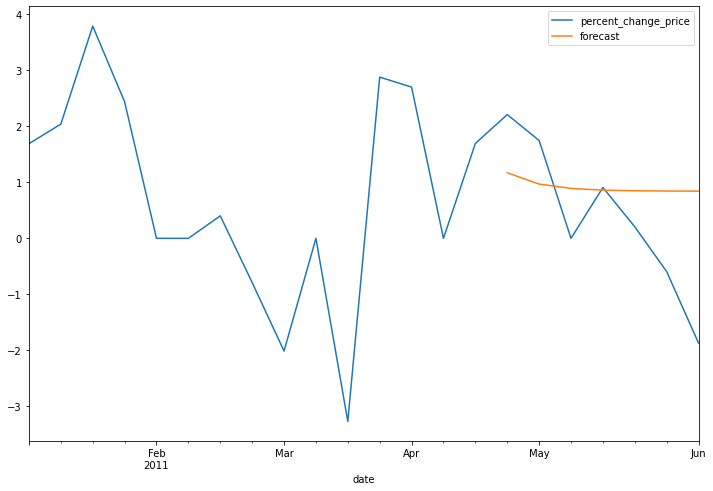

In [17]:
train['forecast']=model_fit.predict(start=15,end=103,dynamic=True)
train[['percent_change_price','forecast']].plot(figsize=(12,8))

# Conclusion:

## Takeaway:

- The model is not great

- there is not enough data to fit and make proper predictions for a time series

- A regression model may have been a better coice for this data set

## Recomendations:

- hold of on implimentation until a better model is built

- Collect more data


## Next Steps:

- Clustering and regression modeling is a good choice for future work

- research other methods of time series analysis

